In [0]:
# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
!pip install talos
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 26.6MB 92kB/s 
     |████████████████████████████████| 839kB 30.6MB/s 
  Created wheel for talos: filename=talos-0.6.3-cp36-none-any.whl size=49626 sha256=429598a01732cca12f51e13d76cde2446b0aed7025531b388dcc8f77c5392f1c
  Stored in directory: /root/.cache/pip/wheels/bb/d7/6b/86fd8b1fc7cfbd2c54796412f86efb5fb6a3a5c734014f6a66
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=2a46c68bd3232a9aa752593b5608b37e784e44b06c13780278fc7887df35ede0
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56960 sha256=7fcad50c2d64c39f095fb33343db2733521792fb3e85b87ac4c283f14f199641
  Stored in directory: /root/.cache/pip/wheels/ae/70/21/c475cd079ec401dd6e1b9b1d42b4c38554ce12679bfb214aad
  Created wheel for chances: filename=chances-0.1.9-cp36-none-any.whl size=41609 sha256=fc316e17f5b7ddb03ef40a307

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [5]:
# Data directory
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [10]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
# Initializing parameters
#epochs = 30
#n_hidden = 10

#param_grid = dict(epochs=[30,40],n_hidden=[10,15,20,25,30,35,40,45,50,55,60])
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(X, Y)

In [0]:
def HAR_LSTM(X_train, Y_train, X_test, Y_test, params):

    model = Sequential()
    model.add(LSTM(params['n_hidden'], input_shape=(timesteps, input_dim)))    
    model.add(Dropout(params['dropout']))
    model.add(Dense(n_classes, activation='sigmoid'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, Y_train,validation_data = (X_test, Y_test),batch_size=40,epochs=30,verbose=0)
    return history, model

Now lets test various combinations of n_hidden ad dropout. We will check for  n_hidden from range 0 to 65 (not all , but at interval of 5) and dropout from range .2 to .8, with internal of .1, (i.e dropout from 20% to 80%)

Now since this will take lot of time and sometimes google colab kicks me out after long period of inactivity within a cell. I am breaking it into chunks

In [0]:
p1 = {'n_hidden':[15,25,35,45,55,65],
     'dropout': [0.2,0.3]}

p2 = {'n_hidden':[10,15,25,35,45,55,65],
     'dropout': [0.4,0.5]}

p3 = {'n_hidden':[10,15,25,35,45,55,65],
     'dropout': [0.6,0.7]}

p4 = {'n_hidden':[10,15,25,35,45,55,65],
     'dropout': [0.8]}

In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t1 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p1,experiment_name='1',disable_progress_bar=False,print_params=True)


  0%|          | 0/12 [00:00<?, ?it/s]

{'dropout': 0.2, 'n_hidden': 15}
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15)                1500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 96        
Total params: 1,596
Trainable params: 1,596
Non-trainable params: 0
_________________________________________________________________




  8%|▊         | 1/12 [04:07<45:20, 247.29s/it]

{'dropout': 0.2, 'n_hidden': 25}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________



 17%|█▋        | 2/12 [08:39<42:26, 254.67s/it]

{'dropout': 0.2, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________



 25%|██▌       | 3/12 [13:37<40:09, 267.75s/it]

{'dropout': 0.2, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________



 33%|███▎      | 4/12 [18:59<37:52, 284.06s/it]

{'dropout': 0.2, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________



 42%|████▏     | 5/12 [24:54<35:37, 305.39s/it]

{'dropout': 0.2, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________



 50%|█████     | 6/12 [30:58<32:17, 322.88s/it]

{'dropout': 0.3, 'n_hidden': 15}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 96        
Total params: 1,596
Trainable params: 1,596
Non-trainable params: 0
_________________________________________________________________



 58%|█████▊    | 7/12 [34:32<24:11, 290.27s/it]

{'dropout': 0.3, 'n_hidden': 25}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________



 67%|██████▋   | 8/12 [38:29<18:16, 274.18s/it]

{'dropout': 0.3, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________



 75%|███████▌  | 9/12 [42:55<13:35, 271.85s/it]

{'dropout': 0.3, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________



 83%|████████▎ | 10/12 [47:44<09:13, 276.87s/it]

{'dropout': 0.3, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________



 92%|█████████▏| 11/12 [53:04<04:49, 289.92s/it]

{'dropout': 0.3, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________



100%|██████████| 12/12 [59:02<00:00, 310.32s/it]


In [0]:
print (t1.data)

    round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0             30  0.535842  0.778332  0.539308  0.780023      0.2        15
1             30  0.443391  0.796464  0.482837  0.785464      0.2        25
2             30  0.456516  0.821850  0.414255  0.853673      0.2        35
3             30  0.320570  0.860834  0.327982  0.870190      0.2        45
4             30  0.327954  0.868540  0.348676  0.878352      0.2        55
5             30  0.153704  0.934723  0.187573  0.932569      0.2        65
6             30  0.748829  0.621940  0.793479  0.557909      0.3        15
7             30  0.628224  0.694016  0.727207  0.665954      0.3        25
8             30  0.568490  0.785131  0.625008  0.763894      0.3        35
9             30  0.219541  0.922484  0.257486  0.913331      0.3        45
10            30  0.736938  0.590209  0.787109  0.576953      0.3        55
11            30  0.261446  0.912511  0.277876  0.907112      0.3        65


In [0]:
analyze_object = ta.Analyze(t1)
print (analyze_object.data)
print ("############")
print (analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss']))


    round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0             30  0.535842  0.778332  0.539308  0.780023      0.2        15
1             30  0.443391  0.796464  0.482837  0.785464      0.2        25
2             30  0.456516  0.821850  0.414255  0.853673      0.2        35
3             30  0.320570  0.860834  0.327982  0.870190      0.2        45
4             30  0.327954  0.868540  0.348676  0.878352      0.2        55
5             30  0.153704  0.934723  0.187573  0.932569      0.2        65
6             30  0.748829  0.621940  0.793479  0.557909      0.3        15
7             30  0.628224  0.694016  0.727207  0.665954      0.3        25
8             30  0.568490  0.785131  0.625008  0.763894      0.3        35
9             30  0.219541  0.922484  0.257486  0.913331      0.3        45
10            30  0.736938  0.590209  0.787109  0.576953      0.3        55
11            30  0.261446  0.912511  0.277876  0.907112      0.3        65
############

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


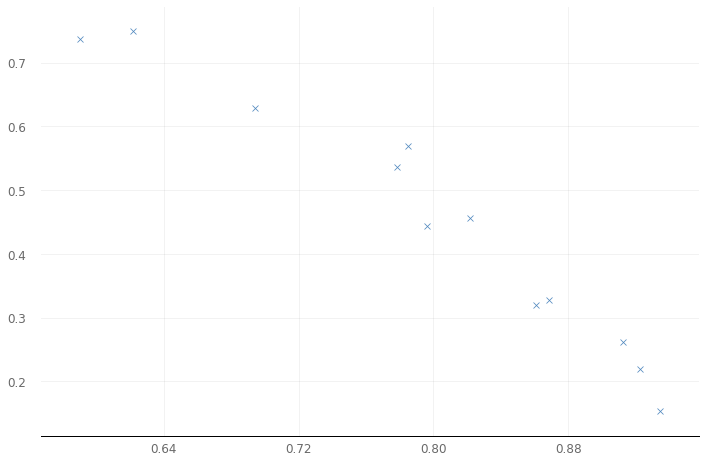

In [0]:
analyze_object.plot_regs('val_acc', 'val_loss')


In [0]:
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])


array([[65. ,  0.2, 30. ,  0. ],
       [45. ,  0.3, 30. ,  1. ],
       [65. ,  0.3, 30. ,  2. ],
       [55. ,  0.2, 30. ,  3. ],
       [45. ,  0.2, 30. ,  4. ],
       [35. ,  0.2, 30. ,  5. ],
       [25. ,  0.2, 30. ,  6. ],
       [35. ,  0.3, 30. ,  7. ],
       [15. ,  0.2, 30. ,  8. ],
       [25. ,  0.3, 30. ,  9. ]])

In [0]:
import talos as ta
import warnings
warnings.filterwarnings('ignore')

t2 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p2,experiment_name='2',disable_progress_bar=False,print_params=True)


  0%|          | 0/14 [00:00<?, ?it/s]

{'dropout': 0.4, 'n_hidden': 10}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 866
Trainable params: 866
Non-trainable params: 0
_________________________________________________________________



  7%|▋         | 1/14 [03:32<46:01, 212.44s/it]

{'dropout': 0.4, 'n_hidden': 15}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 96        
Total params: 1,596
Trainable params: 1,596
Non-trainable params: 0
_________________________________________________________________



 14%|█▍        | 2/14 [07:13<43:01, 215.13s/it]

{'dropout': 0.4, 'n_hidden': 25}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________



 21%|██▏       | 3/14 [11:18<41:03, 223.94s/it]

{'dropout': 0.4, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________



 29%|██▊       | 4/14 [15:48<39:39, 237.93s/it]

{'dropout': 0.4, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________



 36%|███▌      | 5/14 [20:42<38:10, 254.55s/it]

{'dropout': 0.4, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________



 43%|████▎     | 6/14 [26:06<36:43, 275.41s/it]

{'dropout': 0.4, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________



 50%|█████     | 7/14 [32:07<35:07, 301.05s/it]

{'dropout': 0.5, 'n_hidden': 10}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 866
Trainable params: 866
Non-trainable params: 0
_________________________________________________________________



 57%|█████▋    | 8/14 [35:39<27:27, 274.54s/it]

{'dropout': 0.5, 'n_hidden': 15}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 96        
Total params: 1,596
Trainable params: 1,596
Non-trainable params: 0
_________________________________________________________________



 64%|██████▍   | 9/14 [39:22<21:34, 258.91s/it]

{'dropout': 0.5, 'n_hidden': 25}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________



 71%|███████▏  | 10/14 [43:26<16:58, 254.63s/it]

{'dropout': 0.5, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________



 79%|███████▊  | 11/14 [47:58<12:59, 259.70s/it]

{'dropout': 0.5, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________



 86%|████████▌ | 12/14 [52:53<09:00, 270.42s/it]

{'dropout': 0.5, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________



 93%|█████████▎| 13/14 [58:19<04:47, 287.10s/it]

{'dropout': 0.5, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________



100%|██████████| 14/14 [1:04:21<00:00, 309.34s/it]


In [0]:
print (t2.data)

In [0]:
analyze_object2 = ta.Analyze(t2)
print (analyze_object2.data)
print ("############")
print (analyze_object2.best_params('val_acc', ['acc', 'loss', 'val_loss']))


    round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0             30  0.705121  0.683590  0.809682  0.641663      0.4        10
1             30  0.682834  0.692656  0.726294  0.669452      0.4        15
2             30  0.898698  0.699909  1.034566  0.579868      0.4        25
3             30  0.390169  0.867180  0.509215  0.834629      0.4        35
4             30  0.276417  0.906165  0.348644  0.871356      0.4        45
5             30  1.192201  0.476881  1.213438  0.486592      0.4        55
6             30  0.545816  0.781052  0.673832  0.722309      0.4        65
7             30  1.100086  0.472348  1.117126  0.498834      0.5        10
8             30  0.710729  0.640526  0.796891  0.628449      0.5        15
9             30  0.736238  0.630553  0.702828  0.664983      0.5        25
10            30  0.761507  0.648232  0.819030  0.610377      0.5        35
11            30  0.334457  0.890752  0.344861  0.897007      0.5        45
12          

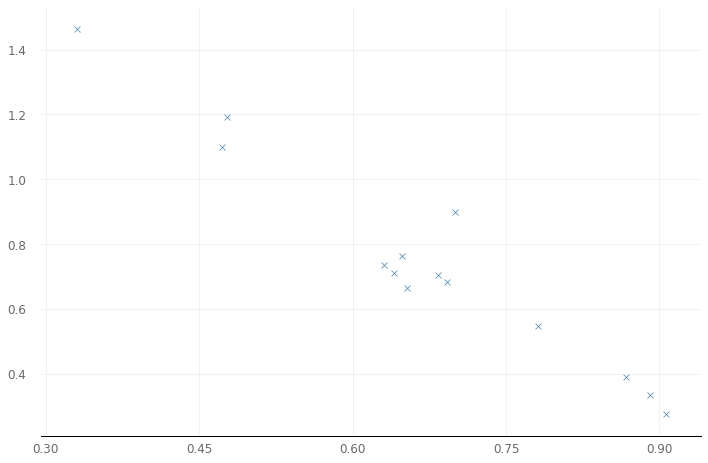

In [0]:
analyze_object2.plot_regs('val_acc', 'val_loss')


In [0]:
analyze_object2.best_params('val_acc', ['acc', 'loss', 'val_loss'])


array([[45. ,  0.4, 30. ,  0. ],
       [45. ,  0.5, 30. ,  1. ],
       [35. ,  0.4, 30. ,  2. ],
       [65. ,  0.4, 30. ,  3. ],
       [25. ,  0.4, 30. ,  4. ],
       [15. ,  0.4, 30. ,  5. ],
       [10. ,  0.4, 30. ,  6. ],
       [55. ,  0.5, 30. ,  7. ],
       [35. ,  0.5, 30. ,  8. ],
       [15. ,  0.5, 30. ,  9. ]])

In [0]:
import talos as ta
import warnings
warnings.filterwarnings('ignore')

t3 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p1,experiment_name='3',disable_progress_bar=False,print_params=True)


  0%|          | 0/12 [00:00<?, ?it/s]

{'dropout': 0.2, 'n_hidden': 15}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 96        
Total params: 1,596
Trainable params: 1,596
Non-trainable params: 0
_________________________________________________________________



  8%|▊         | 1/12 [03:42<40:52, 222.99s/it]

{'dropout': 0.2, 'n_hidden': 25}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________



 17%|█▋        | 2/12 [07:49<38:21, 230.15s/it]

{'dropout': 0.2, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________



 25%|██▌       | 3/12 [12:23<36:27, 243.08s/it]

{'dropout': 0.2, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________



 33%|███▎      | 4/12 [17:17<34:27, 258.41s/it]

{'dropout': 0.2, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________



 42%|████▏     | 5/12 [22:43<32:31, 278.79s/it]

{'dropout': 0.2, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________



 50%|█████     | 6/12 [28:44<30:20, 303.46s/it]

{'dropout': 0.3, 'n_hidden': 15}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 96        
Total params: 1,596
Trainable params: 1,596
Non-trainable params: 0
_________________________________________________________________



 58%|█████▊    | 7/12 [32:26<23:15, 279.10s/it]

{'dropout': 0.3, 'n_hidden': 25}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________



 67%|██████▋   | 8/12 [36:31<17:55, 268.77s/it]

{'dropout': 0.3, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________



 75%|███████▌  | 9/12 [41:04<13:29, 270.00s/it]

{'dropout': 0.3, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________



 83%|████████▎ | 10/12 [45:52<09:10, 275.36s/it]

{'dropout': 0.3, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________



 92%|█████████▏| 11/12 [51:01<04:45, 285.37s/it]

{'dropout': 0.3, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________



100%|██████████| 12/12 [56:43<00:00, 302.59s/it]


In [0]:
print (t3.data)

    round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0             30  0.682995  0.658658  0.722424  0.671784      0.2        15
1             30  1.054739  0.623300  1.085866  0.546444      0.2        25
2             30  0.529008  0.767452  0.535910  0.763311      0.2        35
3             30  0.366875  0.878060  0.409616  0.865138      0.2        45
4             30  0.235800  0.914325  0.272757  0.909444      0.2        55
5             30  0.276946  0.907072  0.276064  0.897007      0.2        65
6             30  0.787219  0.641886  0.996860  0.600661      0.3        15
7             30  0.828878  0.592928  0.877912  0.603964      0.3        25
8             30  0.271579  0.907525  0.237677  0.921492      0.3        35
9             30  0.616223  0.753400  0.724502  0.692771      0.3        45
10            30  0.397681  0.874887  0.445539  0.840070      0.3        55
11            30  0.499969  0.825929  0.602736  0.772445      0.3        65


In [0]:
analyze_object3 = ta.Analyze(t3)
print (analyze_object3.data)
print ("############")
print (analyze_object3.best_params('val_acc', ['acc', 'loss', 'val_loss']))


    round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0             30  0.682995  0.658658  0.722424  0.671784      0.2        15
1             30  1.054739  0.623300  1.085866  0.546444      0.2        25
2             30  0.529008  0.767452  0.535910  0.763311      0.2        35
3             30  0.366875  0.878060  0.409616  0.865138      0.2        45
4             30  0.235800  0.914325  0.272757  0.909444      0.2        55
5             30  0.276946  0.907072  0.276064  0.897007      0.2        65
6             30  0.787219  0.641886  0.996860  0.600661      0.3        15
7             30  0.828878  0.592928  0.877912  0.603964      0.3        25
8             30  0.271579  0.907525  0.237677  0.921492      0.3        35
9             30  0.616223  0.753400  0.724502  0.692771      0.3        45
10            30  0.397681  0.874887  0.445539  0.840070      0.3        55
11            30  0.499969  0.825929  0.602736  0.772445      0.3        65
############

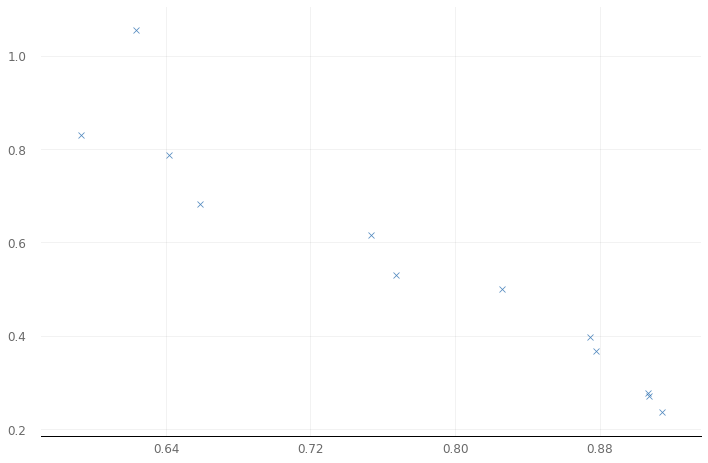

In [0]:
analyze_object3.plot_regs('val_acc', 'val_loss')


In [0]:
analyze_object3.best_params('val_acc', ['acc', 'loss', 'val_loss'])


array([[55. ,  0.2, 30. ,  0. ],
       [35. ,  0.3, 30. ,  1. ],
       [65. ,  0.2, 30. ,  2. ],
       [45. ,  0.2, 30. ,  3. ],
       [55. ,  0.3, 30. ,  4. ],
       [65. ,  0.3, 30. ,  5. ],
       [35. ,  0.2, 30. ,  6. ],
       [45. ,  0.3, 30. ,  7. ],
       [15. ,  0.2, 30. ,  8. ],
       [15. ,  0.3, 30. ,  9. ]])

In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t4 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p4,experiment_name='4',disable_progress_bar=False,print_params=True)

  0%|          | 0/7 [00:00<?, ?it/s]

{'dropout': 0.8, 'n_hidden': 10}



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 866
Trainable params: 866
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









 14%|█▍        | 1/7 [03:41<22:06, 221.17s/it]

{'dropout': 0.8, 'n_hidden': 15}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 96        
Total params: 1,596
Trainable params: 1,596
Non-trainable params: 0
_________________________________________________________________


 29%|██▊       | 2/7 [07:35<18:44, 224.97s/it]

{'dropout': 0.8, 'n_hidden': 25}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________


 43%|████▎     | 3/7 [11:52<15:39, 234.80s/it]

{'dropout': 0.8, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________


 57%|█████▋    | 4/7 [16:48<12:39, 253.05s/it]

{'dropout': 0.8, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________


 71%|███████▏  | 5/7 [22:14<09:09, 274.99s/it]

{'dropout': 0.8, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________


 86%|████████▌ | 6/7 [28:06<04:58, 298.00s/it]

{'dropout': 0.8, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 7/7 [34:33<00:00, 324.88s/it]


In [0]:
print (t4.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.847336  0.603808  1.161567  0.450641      0.8        10
1            30  0.801301  0.633726  1.091286  0.452002      0.8        15
2            30  0.707703  0.662738  0.857464  0.593471      0.8        25
3            30  1.300074  0.365820  1.351471  0.350369      0.8        35
4            30  0.638376  0.661831  0.724587  0.639526      0.8        45
5            30  0.909026  0.611514  1.036294  0.565293      0.8        55
6            30  1.450603  0.503173  0.837978  0.586864      0.8        65


In [0]:
analyze_object4 = ta.Analyze(t4)
print (analyze_object4.data)
print ("############")
print (analyze_object4.best_params('val_acc', ['acc', 'loss', 'val_loss']))


   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.847336  0.603808  1.161567  0.450641      0.8        10
1            30  0.801301  0.633726  1.091286  0.452002      0.8        15
2            30  0.707703  0.662738  0.857464  0.593471      0.8        25
3            30  1.300074  0.365820  1.351471  0.350369      0.8        35
4            30  0.638376  0.661831  0.724587  0.639526      0.8        45
5            30  0.909026  0.611514  1.036294  0.565293      0.8        55
6            30  1.450603  0.503173  0.837978  0.586864      0.8        65
############
[[25.   0.8 30.   0. ]
 [45.   0.8 30.   1. ]
 [15.   0.8 30.   2. ]
 [55.   0.8 30.   3. ]
 [10.   0.8 30.   4. ]
 [65.   0.8 30.   5. ]
 [35.   0.8 30.   6. ]]


findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


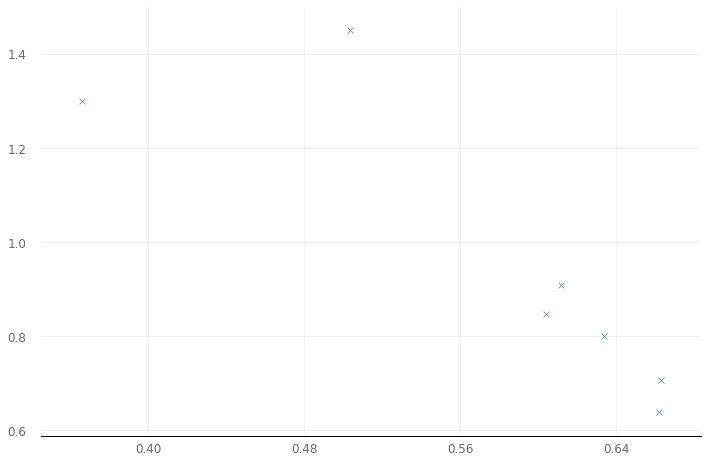

In [0]:
analyze_object4.plot_regs('val_acc', 'val_loss')


In [0]:
analyze_object4.best_params('val_acc', ['acc', 'loss', 'val_loss'])


array([[25. ,  0.8, 30. ,  0. ],
       [45. ,  0.8, 30. ,  1. ],
       [15. ,  0.8, 30. ,  2. ],
       [55. ,  0.8, 30. ,  3. ],
       [10. ,  0.8, 30. ,  4. ],
       [65. ,  0.8, 30. ,  5. ],
       [35. ,  0.8, 30. ,  6. ]])

So i have manually copied all  the combinations which produces best result. Below is the table:
```
round_epochs  val_loss    val_acc    loss      acc         dropout  n_hidden
30             0.153704   0.934723  0.187573  0.932569      0.2        65
30             0.219541   0.922484  0.257486  0.913331      0.3        45
30             0.261446   0.912511  0.277876  0.907112      0.3        65
30             0.271579   0.907525  0.237677  0.921492      0.3        35
30             0.276417   0.906165  0.348644  0.871356      0.4        45
30             0.334457   0.890752  0.344861  0.897007      0.5        45



So we see the best performance is when dropout is less probably reason could be we dont have much points so dropout has to be less. Also when number of neurons is on "bit higher" side then also we have better performance.

So now lets try to further fine tune as per our learnings

In [0]:
p5 = {'n_hidden':[35,40,45,50,55,60,65,70,75],
     'dropout': [0.1]}

p6 = {'n_hidden':[35,40,45,50,55,60,65,70,75],
     'dropout': [0.15]}


In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t5 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p5,experiment_name='5',disable_progress_bar=False,print_params=True)

  0%|          | 0/9 [00:00<?, ?it/s]

{'dropout': 0.1, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________


 11%|█         | 1/9 [04:52<38:58, 292.26s/it]

{'dropout': 0.1, 'n_hidden': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 8,246
Trainable params: 8,246
Non-trainable params: 0
_________________________________________________________________


 22%|██▏       | 2/9 [09:50<34:17, 293.91s/it]

{'dropout': 0.1, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________


 33%|███▎      | 3/9 [15:15<30:19, 303.27s/it]

{'dropout': 0.1, 'n_hidden': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 44%|████▍     | 4/9 [20:55<26:12, 314.54s/it]

{'dropout': 0.1, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________


 56%|█████▌    | 5/9 [26:49<21:44, 326.14s/it]

{'dropout': 0.1, 'n_hidden': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                16800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 17,166
Trainable params: 17,166
Non-trainable params: 0
_________________________________________________________________


 67%|██████▋   | 6/9 [32:59<16:58, 339.54s/it]

{'dropout': 0.1, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________


 78%|███████▊  | 7/9 [40:00<12:07, 363.69s/it]

{'dropout': 0.1, 'n_hidden': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                22400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________


 89%|████████▉ | 8/9 [47:10<06:23, 383.59s/it]

{'dropout': 0.1, 'n_hidden': 75}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                25500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 456       
Total params: 25,956
Trainable params: 25,956
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 9/9 [54:45<00:00, 405.29s/it]


In [0]:
print (t5.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.330125  0.889846  0.343399  0.889623      0.1        35
1            30  0.717082  0.823663  1.053372  0.634473      0.1        40
2            30  0.194613  0.938350  0.199511  0.934512      0.1        45
3            30  0.555475  0.776972  0.603254  0.764672      0.1        50
4            30  0.452976  0.851768  0.537753  0.791683      0.1        55
5            30  0.496540  0.845875  0.646201  0.784493      0.1        60
6            30  0.197542  0.932457  0.212292  0.932569      0.1        65
7            30  0.174414  0.928830  0.170497  0.939565      0.1        70
8            30  0.150804  0.933817  0.146176  0.943257      0.1        75


In [0]:
analyze_object5 = ta.Analyze(t5)
print ("############")
print (analyze_object5.best_params('val_acc', ['acc', 'loss', 'val_loss']))


############
[[45.   0.1 30.   0. ]
 [75.   0.1 30.   1. ]
 [65.   0.1 30.   2. ]
 [70.   0.1 30.   3. ]
 [35.   0.1 30.   4. ]
 [55.   0.1 30.   5. ]
 [60.   0.1 30.   6. ]
 [40.   0.1 30.   7. ]
 [50.   0.1 30.   8. ]]


In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t6 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p6,experiment_name='6',disable_progress_bar=False,print_params=True)

  0%|          | 0/9 [00:00<?, ?it/s]

{'dropout': 0.15, 'n_hidden': 35}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 35)                6300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 216       
Total params: 6,516
Trainable params: 6,516
Non-trainable params: 0
_________________________________________________________________


 11%|█         | 1/9 [05:01<40:15, 301.95s/it]

{'dropout': 0.15, 'n_hidden': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 8,246
Trainable params: 8,246
Non-trainable params: 0
_________________________________________________________________


 22%|██▏       | 2/9 [10:05<35:16, 302.29s/it]

{'dropout': 0.15, 'n_hidden': 45}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45)                9900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 276       
Total params: 10,176
Trainable params: 10,176
Non-trainable params: 0
_________________________________________________________________


 33%|███▎      | 3/9 [15:34<31:02, 310.49s/it]

{'dropout': 0.15, 'n_hidden': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 44%|████▍     | 4/9 [21:22<26:49, 321.84s/it]

{'dropout': 0.15, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________


 56%|█████▌    | 5/9 [27:32<22:24, 336.14s/it]

{'dropout': 0.15, 'n_hidden': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                16800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 17,166
Trainable params: 17,166
Non-trainable params: 0
_________________________________________________________________


 67%|██████▋   | 6/9 [33:47<17:23, 347.70s/it]

{'dropout': 0.15, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________


 78%|███████▊  | 7/9 [40:18<12:01, 360.86s/it]

{'dropout': 0.15, 'n_hidden': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                22400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________


 89%|████████▉ | 8/9 [47:13<06:17, 377.02s/it]

{'dropout': 0.15, 'n_hidden': 75}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                25500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 456       
Total params: 25,956
Trainable params: 25,956
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 9/9 [54:31<00:00, 395.26s/it]


In [0]:
print (t6.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.512010  0.743427  0.523001  0.758842     0.15        35
1            30  0.655865  0.666364  0.525803  0.764866     0.15        40
2            30  0.242144  0.929737  0.417031  0.881073     0.15        45
3            30  0.371006  0.850861  0.461848  0.818500     0.15        50
4            30  0.173087  0.938803  0.191239  0.938787     0.15        55
5            30  0.189247  0.935630  0.174809  0.934512     0.15        60
6            30  0.935341  0.589755  1.214595  0.543529     0.15        65
7            30  0.269311  0.907525  0.320584  0.888263     0.15        70
8            30  0.168008  0.926111  0.168829  0.926739     0.15        75


In [0]:
analyze_object6 = ta.Analyze(t6)
print ("############")
print (analyze_object6.best_params('val_acc', ['acc', 'loss', 'val_loss']))


############
[[55.    0.15 30.    0.  ]
 [60.    0.15 30.    1.  ]
 [45.    0.15 30.    2.  ]
 [75.    0.15 30.    3.  ]
 [70.    0.15 30.    4.  ]
 [50.    0.15 30.    5.  ]
 [35.    0.15 30.    6.  ]
 [40.    0.15 30.    7.  ]
 [65.    0.15 30.    8.  ]]


In [0]:
p7 = {'n_hidden':[50,55,60,65,70,75,80],
     'dropout': [0.2]}

p8 = {'n_hidden':[50,55,60,65,70,75,80],
     'dropout': [0.25]}

p9 = {'n_hidden':[50,55,60,65,70,75,80],
     'dropout': [0.3]}

p10 = {'n_hidden':[50,55,60,65,70,75,80],
     'dropout': [0.35]}

In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t7 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p7,experiment_name='7',disable_progress_bar=False,print_params=True)



  0%|          | 0/7 [00:00<?, ?it/s]

{'dropout': 0.2, 'n_hidden': 50}
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________




 14%|█▍        | 1/7 [05:34<33:29, 334.84s/it]

{'dropout': 0.2, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________




 29%|██▊       | 2/7 [11:31<28:26, 341.29s/it]

{'dropout': 0.2, 'n_hidden': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                16800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 17,166
Trainable params: 17,166
Non-trainable params: 0
_________________________________________________________________




 43%|████▎     | 3/7 [17:54<23:35, 353.90s/it]

{'dropout': 0.2, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________




 57%|█████▋    | 4/7 [24:51<18:38, 372.95s/it]

{'dropout': 0.2, 'n_hidden': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                22400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________




 71%|███████▏  | 5/7 [31:40<12:47, 383.79s/it]

{'dropout': 0.2, 'n_hidden': 75}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                25500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 456       
Total params: 25,956
Trainable params: 25,956
Non-trainable params: 0
_________________________________________________________________




 86%|████████▌ | 6/7 [38:56<06:39, 399.18s/it]

{'dropout': 0.2, 'n_hidden': 80}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                28800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 29,286
Trainable params: 29,286
Non-trainable params: 0
_________________________________________________________________




100%|██████████| 7/7 [46:05<00:00, 408.28s/it]



In [0]:
print (t7.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.460079  0.818676  0.461717  0.814419      0.2        50
1            30  0.429562  0.818676  0.324850  0.883599      0.2        55
2            30  0.169819  0.925657  0.188048  0.934124      0.2        60
3            30  0.547212  0.724388  0.541891  0.719394      0.2        65
4            30  0.217526  0.916138  0.225114  0.928294      0.2        70
5            30  0.221293  0.915231  0.179503  0.936650      0.2        75
6            30  0.276090  0.902992  0.402867  0.879907      0.2        80


In [0]:
analyze_object7 = ta.Analyze(t7)
print ("############")
print (analyze_object7.best_params('val_acc', ['acc', 'loss', 'val_loss']))


############
[[60.   0.2 30.   0. ]
 [70.   0.2 30.   1. ]
 [75.   0.2 30.   2. ]
 [80.   0.2 30.   3. ]
 [50.   0.2 30.   4. ]
 [55.   0.2 30.   5. ]
 [65.   0.2 30.   6. ]]


In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t8 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p8,experiment_name='8',disable_progress_bar=False,print_params=True)



  0%|          | 0/7 [00:00<?, ?it/s]

{'dropout': 0.25, 'n_hidden': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________




 14%|█▍        | 1/7 [05:43<34:18, 343.14s/it]

{'dropout': 0.25, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________




 29%|██▊       | 2/7 [11:46<29:06, 349.23s/it]

{'dropout': 0.25, 'n_hidden': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                16800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 17,166
Trainable params: 17,166
Non-trainable params: 0
_________________________________________________________________




 43%|████▎     | 3/7 [18:01<23:47, 356.97s/it]

{'dropout': 0.25, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________




 57%|█████▋    | 4/7 [24:38<18:27, 369.08s/it]

{'dropout': 0.25, 'n_hidden': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                22400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________




 71%|███████▏  | 5/7 [31:25<12:40, 380.40s/it]

{'dropout': 0.25, 'n_hidden': 75}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                25500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 456       
Total params: 25,956
Trainable params: 25,956
Non-trainable params: 0
_________________________________________________________________




 86%|████████▌ | 6/7 [38:55<06:41, 401.16s/it]

{'dropout': 0.25, 'n_hidden': 80}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                28800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 29,286
Trainable params: 29,286
Non-trainable params: 0
_________________________________________________________________




100%|██████████| 7/7 [46:04<00:00, 409.56s/it]



In [0]:
print (t8.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.385329  0.866274  0.420450  0.838321     0.25        50
1            30  0.238181  0.913418  0.315607  0.903031     0.25        55
2            30  0.232557  0.915684  0.234352  0.914497     0.25        60
3            30  0.506204  0.771532  0.549081  0.749320     0.25        65
4            30  0.427905  0.775612  0.411445  0.817140     0.25        70
5            30  0.171499  0.927924  0.194620  0.929265     0.25        75
6            30  0.290419  0.898005  0.331445  0.889234     0.25        80


In [0]:
analyze_object8 = ta.Analyze(t8)
print ("############")
print (analyze_object8.best_params('val_acc', ['acc', 'loss', 'val_loss']))


############
[[75.    0.25 30.    0.  ]
 [60.    0.25 30.    1.  ]
 [55.    0.25 30.    2.  ]
 [80.    0.25 30.    3.  ]
 [50.    0.25 30.    4.  ]
 [70.    0.25 30.    5.  ]
 [65.    0.25 30.    6.  ]]


In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t9 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p9,experiment_name='9',disable_progress_bar=False,print_params=True)



  0%|          | 0/7 [00:00<?, ?it/s]

{'dropout': 0.3, 'n_hidden': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________




 14%|█▍        | 1/7 [05:42<34:15, 342.55s/it]

{'dropout': 0.3, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________




 29%|██▊       | 2/7 [11:41<28:56, 347.40s/it]

{'dropout': 0.3, 'n_hidden': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                16800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 17,166
Trainable params: 17,166
Non-trainable params: 0
_________________________________________________________________




 43%|████▎     | 3/7 [17:57<23:44, 356.03s/it]

{'dropout': 0.3, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________




 57%|█████▋    | 4/7 [24:35<18:25, 368.62s/it]

{'dropout': 0.3, 'n_hidden': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                22400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________




 71%|███████▏  | 5/7 [31:23<12:40, 380.32s/it]

{'dropout': 0.3, 'n_hidden': 75}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                25500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 456       
Total params: 25,956
Trainable params: 25,956
Non-trainable params: 0
_________________________________________________________________




 86%|████████▌ | 6/7 [38:34<06:35, 395.69s/it]

{'dropout': 0.3, 'n_hidden': 80}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                28800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 29,286
Trainable params: 29,286
Non-trainable params: 0
_________________________________________________________________




100%|██████████| 7/7 [45:37<00:00, 403.73s/it]



In [0]:
print (t9.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.537964  0.682230  0.562778  0.699767      0.3        50
1            30  0.300200  0.887126  0.342550  0.890789      0.3        55
2            30  0.614890  0.778785  0.283760  0.905752      0.3        60
3            30  0.162949  0.940617  0.188429  0.938787      0.3        65
4            30  0.599148  0.720762  0.689545  0.690245      0.3        70
5            30  0.805204  0.719855  1.004682  0.664983      0.3        75
6            30  0.601065  0.797824  0.317339  0.890983      0.3        80


In [0]:
analyze_object9 = ta.Analyze(t9)
print (analyze_object9.best_params('val_acc', ['acc', 'loss', 'val_loss']))


[[65.   0.3 30.   0. ]
 [55.   0.3 30.   1. ]
 [80.   0.3 30.   2. ]
 [60.   0.3 30.   3. ]
 [70.   0.3 30.   4. ]
 [75.   0.3 30.   5. ]
 [50.   0.3 30.   6. ]]


In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t10 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p10,experiment_name='10',disable_progress_bar=False,print_params=True)



  0%|          | 0/7 [00:00<?, ?it/s]

{'dropout': 0.35, 'n_hidden': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________




 14%|█▍        | 1/7 [05:38<33:49, 338.30s/it]

{'dropout': 0.35, 'n_hidden': 55}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 336       
Total params: 14,636
Trainable params: 14,636
Non-trainable params: 0
_________________________________________________________________




 29%|██▊       | 2/7 [11:32<28:35, 343.08s/it]

{'dropout': 0.35, 'n_hidden': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                16800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 17,166
Trainable params: 17,166
Non-trainable params: 0
_________________________________________________________________




 43%|████▎     | 3/7 [17:40<23:22, 350.58s/it]

{'dropout': 0.35, 'n_hidden': 65}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 65)                19500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 396       
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________




 57%|█████▋    | 4/7 [24:10<18:07, 362.40s/it]

{'dropout': 0.35, 'n_hidden': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                22400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 22,826
Trainable params: 22,826
Non-trainable params: 0
_________________________________________________________________




 71%|███████▏  | 5/7 [31:03<12:35, 377.52s/it]

{'dropout': 0.35, 'n_hidden': 75}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                25500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 456       
Total params: 25,956
Trainable params: 25,956
Non-trainable params: 0
_________________________________________________________________




 86%|████████▌ | 6/7 [38:19<06:35, 395.21s/it]

{'dropout': 0.35, 'n_hidden': 80}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                28800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 29,286
Trainable params: 29,286
Non-trainable params: 0
_________________________________________________________________




100%|██████████| 7/7 [45:24<00:00, 404.16s/it]



In [0]:
print (t10.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.737335  0.635993  0.789538  0.629615     0.35        50
1            30  0.477936  0.809610  0.545819  0.769724     0.35        55
2            30  0.193315  0.941976  0.245772  0.921104     0.35        60
3            30  0.407638  0.803264  0.484697  0.785076     0.35        65
4            30  0.231399  0.917498  0.277376  0.894287     0.35        70
5            30  0.604080  0.715775  0.645414  0.694520     0.35        75
6            30  0.354007  0.844968  0.430728  0.834629     0.35        80


In [0]:
analyze_object10 = ta.Analyze(t10)
print ("############")
print (analyze_object10.best_params('val_acc', ['acc', 'loss', 'val_loss']))


############
[[60.    0.35 30.    0.  ]
 [70.    0.35 30.    1.  ]
 [80.    0.35 30.    2.  ]
 [55.    0.35 30.    3.  ]
 [65.    0.35 30.    4.  ]
 [75.    0.35 30.    5.  ]
 [50.    0.35 30.    6.  ]]


In [0]:
p11 = {'n_hidden':[85,95,100,110],
     'dropout': [0.1,.05]}



In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t11 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p11,experiment_name='11',disable_progress_bar=False,print_params=True)



  0%|          | 0/8 [00:00<?, ?it/s]

{'dropout': 0.1, 'n_hidden': 85}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 85)                32300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 85)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 516       
Total params: 32,816
Trainable params: 32,816
Non-trainable params: 0
_________________________________________________________________




 12%|█▎        | 1/8 [09:13<1:04:36, 553.82s/it]

{'dropout': 0.1, 'n_hidden': 95}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 95)                39900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 576       
Total params: 40,476
Trainable params: 40,476
Non-trainable params: 0
_________________________________________________________________




 25%|██▌       | 2/8 [18:21<55:12, 552.03s/it]  

{'dropout': 0.1, 'n_hidden': 100}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 44,606
Trainable params: 44,606
Non-trainable params: 0
_________________________________________________________________




 38%|███▊      | 3/8 [27:39<46:09, 553.84s/it]

{'dropout': 0.1, 'n_hidden': 110}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 110)               52800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 110)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 666       
Total params: 53,466
Trainable params: 53,466
Non-trainable params: 0
_________________________________________________________________




 50%|█████     | 4/8 [37:54<38:08, 572.03s/it]

{'dropout': 0.05, 'n_hidden': 85}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 85)                32300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 85)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 516       
Total params: 32,816
Trainable params: 32,816
Non-trainable params: 0
_________________________________________________________________




 62%|██████▎   | 5/8 [46:09<27:26, 548.86s/it]

{'dropout': 0.05, 'n_hidden': 95}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 95)                39900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 576       
Total params: 40,476
Trainable params: 40,476
Non-trainable params: 0
_________________________________________________________________




 75%|███████▌  | 6/8 [54:56<18:04, 542.49s/it]

{'dropout': 0.05, 'n_hidden': 100}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 44,606
Trainable params: 44,606
Non-trainable params: 0
_________________________________________________________________




 88%|████████▊ | 7/8 [1:04:10<09:05, 545.92s/it]

{'dropout': 0.05, 'n_hidden': 110}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 110)               52800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 110)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 666       
Total params: 53,466
Trainable params: 53,466
Non-trainable params: 0
_________________________________________________________________




100%|██████████| 8/8 [1:14:20<00:00, 565.13s/it]



In [0]:
print (t11.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.169475  0.940617  0.183592  0.932569     0.10        85
1            30  0.189383  0.927471  0.220780  0.919938     0.10        95
2            30  0.436723  0.817316  0.426182  0.819471     0.10       100
3            30  0.138878  0.934723  0.146630  0.941897     0.10       110
4            30  0.147089  0.936990  0.177823  0.935290     0.05        85
5            30  0.322639  0.864007  0.235360  0.912165     0.05        95
6            30  0.133119  0.946963  0.141348  0.946949     0.05       100
7            30  0.156973  0.936537  0.159637  0.938010     0.05       110


In [0]:
analyze_object11 = ta.Analyze(t11)
print ("############")
print (analyze_object11.best_params('val_acc', ['acc', 'loss', 'val_loss']))


############
[[1.0e+02 5.0e-02 3.0e+01 0.0e+00]
 [8.5e+01 1.0e-01 3.0e+01 1.0e+00]
 [8.5e+01 5.0e-02 3.0e+01 2.0e+00]
 [1.1e+02 5.0e-02 3.0e+01 3.0e+00]
 [1.1e+02 1.0e-01 3.0e+01 4.0e+00]
 [9.5e+01 1.0e-01 3.0e+01 5.0e+00]
 [9.5e+01 5.0e-02 3.0e+01 6.0e+00]
 [1.0e+02 1.0e-01 3.0e+01 7.0e+00]]


So we see as number of hidden layers is increasing the model is performing better, may be all those layers are learning many other different aspects. Let us keep increasing hidden layers a bit more if it still gives better performance becuase it is likely at one point with too many hidden layer model would tend towards overfitting

In [0]:
p12 = {'n_hidden':[115,120,125,130],
     'dropout': [0.1,.05,0]}



In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t12 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM,params=p12,experiment_name='12',disable_progress_bar=False,print_params=True)

  0%|          | 0/12 [00:00<?, ?it/s]

{'dropout': 0.1, 'n_hidden': 115}



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 115)               57500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 115)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 696       
Total params: 58,196
Trainable params: 58,196
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









  8%|▊         | 1/12 [09:20<1:42:50, 560.96s/it]

{'dropout': 0.1, 'n_hidden': 120}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120)               62400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 726       
Total params: 63,126
Trainable params: 63,126
Non-trainable params: 0
_________________________________________________________________


 17%|█▋        | 2/12 [18:25<1:32:39, 555.92s/it]

{'dropout': 0.1, 'n_hidden': 125}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 125)               67500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 756       
Total params: 68,256
Trainable params: 68,256
Non-trainable params: 0
_________________________________________________________________


 25%|██▌       | 3/12 [28:42<1:26:08, 574.29s/it]

{'dropout': 0.1, 'n_hidden': 130}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 130)               72800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 786       
Total params: 73,586
Trainable params: 73,586
Non-trainable params: 0
_________________________________________________________________


 33%|███▎      | 4/12 [39:53<1:20:27, 603.44s/it]

{'dropout': 0.05, 'n_hidden': 115}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 115)               57500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 115)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 696       
Total params: 58,196
Trainable params: 58,196
Non-trainable params: 0
_________________________________________________________________


 42%|████▏     | 5/12 [49:46<1:10:01, 600.17s/it]

{'dropout': 0.05, 'n_hidden': 120}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120)               62400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 726       
Total params: 63,126
Trainable params: 63,126
Non-trainable params: 0
_________________________________________________________________


 50%|█████     | 6/12 [58:59<58:35, 585.94s/it]  

{'dropout': 0.05, 'n_hidden': 125}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 125)               67500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 756       
Total params: 68,256
Trainable params: 68,256
Non-trainable params: 0
_________________________________________________________________


 58%|█████▊    | 7/12 [1:09:21<49:45, 597.03s/it]

{'dropout': 0.05, 'n_hidden': 130}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 130)               72800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 786       
Total params: 73,586
Trainable params: 73,586
Non-trainable params: 0
_________________________________________________________________


 67%|██████▋   | 8/12 [1:20:30<41:14, 618.62s/it]

{'dropout': 0, 'n_hidden': 115}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 115)               57500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 115)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 696       
Total params: 58,196
Trainable params: 58,196
Non-trainable params: 0
_________________________________________________________________


 75%|███████▌  | 9/12 [1:29:58<30:09, 603.28s/it]

{'dropout': 0, 'n_hidden': 120}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120)               62400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 726       
Total params: 63,126
Trainable params: 63,126
Non-trainable params: 0
_________________________________________________________________


 83%|████████▎ | 10/12 [1:39:19<19:41, 590.62s/it]

{'dropout': 0, 'n_hidden': 125}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 125)               67500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 756       
Total params: 68,256
Trainable params: 68,256
Non-trainable params: 0
_________________________________________________________________


 92%|█████████▏| 11/12 [1:49:48<10:02, 602.26s/it]

{'dropout': 0, 'n_hidden': 130}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 130)               72800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 786       
Total params: 73,586
Trainable params: 73,586
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 12/12 [2:01:06<00:00, 625.00s/it]


In [0]:
print (t12.data)

    round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0             30  0.193071  0.937897  0.234547  0.923824     0.10       115
1             30  0.181182  0.943790  0.147256  0.944423     0.10       120
2             30  0.212689  0.925204  0.267440  0.904975     0.10       125
3             30  0.202970  0.923844  0.171337  0.933152     0.10       130
4             30  0.389932  0.789665  0.388207  0.797318     0.05       115
5             30  0.363179  0.859927  0.387026  0.860474     0.05       120
6             30  0.303743  0.893472  0.368476  0.875437     0.05       125
7             30  0.269691  0.900272  0.217916  0.921104     0.05       130
8             30  0.135911  0.949683  0.123179  0.952779     0.00       115
9             30  0.160289  0.943336  0.169015  0.937038     0.00       120
10            30  0.173481  0.936083  0.154281  0.942285     0.00       125
11            30  0.292276  0.898005  0.349568  0.850175     0.00       130


So far we have tried several combination of n_hidden and dropout and the best model is with **n_hidden = 115 & dropout= 0**
The values is 


```
round_epochs  val_loss   val_acc      loss       acc          dropout  n_hidden
30            0.135911   0.949683     0.123179   0.952779     0.00       115

```


So for single layer model we have achieved our task as it is pretty close to 96% as per the assignment

Now lets perform the same task for two layered LSTM

In [0]:
def HAR_LSTM2(X_train, Y_train, X_test, Y_test, params):

    model2 = Sequential()
    model2.add(LSTM(params['n_hidden'], input_shape=(timesteps, input_dim),return_sequences = True))    
    model2.add(Dropout(params['dropout']))
    model2.add(LSTM(params['n_hidden']))    
    model2.add(Dropout(params['dropout']))
    model2.add(Dense(n_classes, activation='sigmoid'))
    model2.summary()
    model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history2 = model2.fit(X_train, Y_train,validation_data = (X_test, Y_test),batch_size=40,epochs=30,verbose=0)
    return history2, model2

In [0]:
p2_1 = {'n_hidden':[20,30,40],
     'dropout': [0.25,0.35]}

p2_2 = {'n_hidden':[20,30,40],
     'dropout': [0.45,0.55]}

p2_3 = {'n_hidden':[20,30,40],
     'dropout': [0.65,0.75]}

p2_4 = {'n_hidden':[50,60,70],
     'dropout': [0.25,0.35]}

p2_5 = {'n_hidden':[50,60,70],
     'dropout': [0.45,0.55]}



In [0]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t13 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM2,params=p2_1,experiment_name='model2_1',disable_progress_bar=False,print_params=True)






  0%|          | 0/6 [00:00<?, ?it/s]

{'dropout': 0.25, 'n_hidden': 20}
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 20)           2400      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 20)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
Total params: 5,806
Trainable params: 5,806
Non-trainable params: 0
_________________________________________________________________







 17%|█▋        | 1/6 [08:35<42:59, 515.92s/it]

{'dropout': 0.25, 'n_hidden': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________







 33%|███▎      | 2/6 [18:06<35:29, 532.40s/it]

{'dropout': 0.25, 'n_hidden': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 40)           8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 40)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 21,206
Trainable params: 21,206
Non-trainable params: 0
_________________________________________________________________







 50%|█████     | 3/6 [28:04<27:36, 552.11s/it]

{'dropout': 0.35, 'n_hidden': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 20)           2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 20)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 5,806
Trainable params: 5,806
Non-trainable params: 0
_________________________________________________________________







 67%|██████▋   | 4/6 [36:33<17:57, 538.95s/it]

{'dropout': 0.35, 'n_hidden': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________







 83%|████████▎ | 5/6 [46:00<09:07, 547.45s/it]

{'dropout': 0.35, 'n_hidden': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 40)           8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 40)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 21,206
Trainable params: 21,206
Non-trainable params: 0
_________________________________________________________________







100%|██████████| 6/6 [56:02<00:00, 563.95s/it]






In [0]:
print (t13.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.549964  0.656392  0.638225  0.652934     0.25        20
1            30  0.151043  0.945150  0.176032  0.939953     0.25        30
2            30  0.207792  0.931550  0.255067  0.905752     0.25        40
3            30  0.681467  0.655485  0.656454  0.658181     0.35        20
4            30  0.279739  0.913871  0.386851  0.848037     0.35        30
5            30  0.137708  0.945150  0.158519  0.946366     0.35        40


In [18]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t14 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM2,params=p2_2,experiment_name='model2_2',disable_progress_bar=False,print_params=True)

  0%|          | 0/6 [00:00<?, ?it/s]

{'dropout': 0.45, 'n_hidden': 20}



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 20)           2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 20)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 5,806
Trainable params: 5,806
Non-trainable params: 0
________________________________

 17%|█▋        | 1/6 [08:26<42:14, 506.98s/it]

{'dropout': 0.45, 'n_hidden': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 33%|███▎      | 2/6 [17:53<34:58, 524.72s/it]

{'dropout': 0.45, 'n_hidden': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 40)           8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 40)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 21,206
Trainable params: 21,206
Non-trainable params: 0
_________________________________________________________________


 50%|█████     | 3/6 [27:50<27:19, 546.49s/it]

{'dropout': 0.55, 'n_hidden': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 20)           2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 20)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 5,806
Trainable params: 5,806
Non-trainable params: 0
_________________________________________________________________


 67%|██████▋   | 4/6 [36:14<17:47, 533.82s/it]

{'dropout': 0.55, 'n_hidden': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 83%|████████▎ | 5/6 [45:38<09:02, 542.74s/it]

{'dropout': 0.55, 'n_hidden': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 40)           8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 40)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 21,206
Trainable params: 21,206
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 6/6 [55:53<00:00, 564.39s/it]


In [19]:
print (t14.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.535799  0.753400  0.616080  0.729304     0.45        20
1            30  0.281774  0.893019  0.253964  0.922658     0.45        30
2            30  0.197427  0.932910  0.230404  0.934124     0.45        40
3            30  0.327668  0.874887  0.433183  0.808978     0.55        20
4            30  0.412715  0.797824  0.524392  0.766809     0.55        30
5            30  0.136556  0.953309  0.181004  0.942285     0.55        40


In [20]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t15 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM2,params=p2_3,experiment_name='model2_3',disable_progress_bar=False,print_params=True)

  0%|          | 0/6 [00:00<?, ?it/s]

{'dropout': 0.65, 'n_hidden': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 20)           2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 20)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 5,806
Trainable params: 5,806
Non-trainable params: 0
_________________________________________________________________


 17%|█▋        | 1/6 [08:29<42:25, 509.20s/it]

{'dropout': 0.65, 'n_hidden': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 33%|███▎      | 2/6 [17:50<34:59, 524.95s/it]

{'dropout': 0.65, 'n_hidden': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 40)           8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 40)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 21,206
Trainable params: 21,206
Non-trainable params: 0
_________________________________________________________________


 50%|█████     | 3/6 [27:44<27:17, 545.69s/it]

{'dropout': 0.75, 'n_hidden': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 20)           2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 20)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 5,806
Trainable params: 5,806
Non-trainable params: 0
_________________________________________________________________


 67%|██████▋   | 4/6 [36:41<18:05, 542.89s/it]

{'dropout': 0.75, 'n_hidden': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 83%|████████▎ | 5/6 [46:43<09:20, 560.76s/it]

{'dropout': 0.75, 'n_hidden': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 40)           8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 40)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 21,206
Trainable params: 21,206
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 6/6 [57:15<00:00, 582.11s/it]


In [21]:
print (t15.data)

   round_epochs  val_loss   val_acc      loss       acc  dropout  n_hidden
0            30  0.748448  0.552131  0.844831  0.520793     0.65        20
1            30  0.767729  0.547144  0.792430  0.541586     0.65        30
2            30  0.398223  0.782865  0.505868  0.771279     0.65        40
3            30  0.759821  0.623753  0.848751  0.548581     0.75        20
4            30  0.627152  0.657298  0.725223  0.631170     0.75        30
5            30  0.739763  0.550317  0.761245  0.537505     0.75        40


In [0]:
 def HAR_LSTM3(X_train, Y_train, X_test, Y_test, params):

    model3 = Sequential()
    model3.add(LSTM(params['n_hidden1'], input_shape=(timesteps, input_dim),return_sequences = True))    
    model3.add(Dropout(params['dropout1']))
    model3.add(LSTM(params['n_hidden2']))    
    model3.add(Dropout(params['dropout2']))
    model3.add(Dense(n_classes, activation='sigmoid'))
    model3.summary()
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history3 = model3.fit(X_train, Y_train,validation_data = (X_test, Y_test),batch_size=40,epochs=30,verbose=0)
    return history3, model3

In [0]:
p_3_1 = {'n_hidden1':[30],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.25],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_2 = {'n_hidden1':[30],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.35],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_3 = {'n_hidden1':[30],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.45],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_4 = {'n_hidden1':[30],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.55],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_5 = {'n_hidden1':[30],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.65],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_6 = {'n_hidden1':[40],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.25],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_7 = {'n_hidden1':[40],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.35],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_8 = {'n_hidden1':[40],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.45],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_9 = {'n_hidden1':[40],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.55],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_10 = {'n_hidden1':[50],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.65],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_11 = {'n_hidden1':[50],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.25],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_12 = {'n_hidden1':[50],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.35],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_13 = {'n_hidden1':[50],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.45],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_14 = {'n_hidden1':[50],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.55],'dropout2': [0.25,0.35,0.45,0.55,0.65]}
p_3_15 = {'n_hidden1':[50],'n_hidden2':[20,30,40,50,60,70],'dropout1': [0.65],'dropout2': [0.25,0.35,0.45,0.55,0.65]}

In [30]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t13 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM3,params=p_3_1,experiment_name='model3_1',disable_progress_bar=False,print_params=True)




  0%|          | 0/30 [00:00<?, ?it/s]

{'dropout1': 0.25, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________





  3%|▎         | 1/30 [10:07<4:53:46, 607.80s/it]

{'dropout1': 0.25, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________





  7%|▋         | 2/30 [20:31<4:45:54, 612.67s/it]

{'dropout1': 0.25, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________





 10%|█         | 3/30 [31:25<4:41:10, 624.83s/it]

{'dropout1': 0.25, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________





 13%|█▎        | 4/30 [42:43<4:37:40, 640.78s/it]

{'dropout1': 0.25, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________





 17%|█▋        | 5/30 [53:53<4:30:44, 649.80s/it]

{'dropout1': 0.25, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________





 20%|██        | 6/30 [1:05:50<4:27:56, 669.87s/it]

{'dropout1': 0.25, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________





 23%|██▎       | 7/30 [1:14:56<4:02:34, 632.81s/it]

{'dropout1': 0.25, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________





 27%|██▋       | 8/30 [1:24:19<3:44:15, 611.63s/it]

{'dropout1': 0.25, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________





 30%|███       | 9/30 [1:34:05<3:31:27, 604.19s/it]

{'dropout1': 0.25, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________





 33%|███▎      | 10/30 [1:45:01<3:26:34, 619.73s/it]

{'dropout1': 0.25, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________





 37%|███▋      | 11/30 [1:56:41<3:23:48, 643.58s/it]

{'dropout1': 0.25, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________





 40%|████      | 12/30 [2:08:49<3:20:41, 668.99s/it]

{'dropout1': 0.25, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________





 43%|████▎     | 13/30 [2:18:15<3:00:47, 638.09s/it]

{'dropout1': 0.25, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________





 47%|████▋     | 14/30 [2:27:57<2:45:40, 621.26s/it]

{'dropout1': 0.25, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________





 50%|█████     | 15/30 [2:38:02<2:34:06, 616.41s/it]

{'dropout1': 0.25, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________





 53%|█████▎    | 16/30 [2:48:53<2:26:15, 626.84s/it]

{'dropout1': 0.25, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________





 57%|█████▋    | 17/30 [3:00:26<2:20:04, 646.52s/it]

{'dropout1': 0.25, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________





 60%|██████    | 18/30 [3:12:46<2:14:54, 674.53s/it]

{'dropout1': 0.25, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________





 63%|██████▎   | 19/30 [3:22:23<1:58:20, 645.51s/it]

{'dropout1': 0.25, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________





 67%|██████▋   | 20/30 [3:32:35<1:45:53, 635.39s/it]

{'dropout1': 0.25, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________





 70%|███████   | 21/30 [3:42:52<1:34:27, 629.78s/it]

{'dropout1': 0.25, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________





 73%|███████▎  | 22/30 [3:53:53<1:25:13, 639.20s/it]

{'dropout1': 0.25, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________





 77%|███████▋  | 23/30 [4:05:34<1:16:44, 657.77s/it]

{'dropout1': 0.25, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________





 80%|████████  | 24/30 [4:18:10<1:08:43, 687.18s/it]

{'dropout1': 0.25, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________





 83%|████████▎ | 25/30 [4:27:46<54:28, 653.78s/it]  

{'dropout1': 0.25, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________





 87%|████████▋ | 26/30 [4:37:45<42:29, 637.29s/it]

{'dropout1': 0.25, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________





 90%|█████████ | 27/30 [4:48:00<31:32, 630.70s/it]

{'dropout1': 0.25, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________





 93%|█████████▎| 28/30 [4:59:31<21:37, 648.76s/it]

{'dropout1': 0.25, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________





 97%|█████████▋| 29/30 [5:11:40<11:12, 672.82s/it]

{'dropout1': 0.25, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________





100%|██████████| 30/30 [5:24:27<00:00, 701.21s/it]




In [35]:
print (t13.data)
print ("###########")
reporting13 = ta.Reporting(t13)
print(reporting13.data.columns)

    round_epochs  val_loss   val_acc  ...  dropout2  n_hidden1  n_hidden2
0             30  0.669050  0.722121  ...      0.25         30         20
1             30  0.148767  0.943336  ...      0.25         30         30
2             30  0.137279  0.946510  ...      0.25         30         40
3             30  0.184937  0.935177  ...      0.25         30         50
4             30  0.235827  0.915684  ...      0.25         30         60
5             30  0.140976  0.947869  ...      0.25         30         70
6             30  0.448976  0.797371  ...      0.35         30         20
7             30  0.201816  0.920218  ...      0.35         30         30
8             30  0.321066  0.895286  ...      0.35         30         40
9             30  0.271972  0.915684  ...      0.35         30         50
10            30  0.131506  0.943790  ...      0.35         30         60
11            30  0.161015  0.940163  ...      0.35         30         70
12            30  0.361689  0.792384  

In [19]:
import talos as ta
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

t16 = ta.Scan(x=X_train,y=Y_train,model=HAR_LSTM3,params=p_3_2,experiment_name='model3_2',disable_progress_bar=False,print_params=True)

  0%|          | 0/30 [00:00<?, ?it/s]

{'dropout1': 0.35, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 20}



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable param

  3%|▎         | 1/30 [09:20<4:31:04, 560.86s/it]

{'dropout1': 0.35, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


  7%|▋         | 2/30 [19:11<4:25:57, 569.90s/it]

{'dropout1': 0.35, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________


 10%|█         | 3/30 [29:23<4:22:07, 582.49s/it]

{'dropout1': 0.35, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________


 13%|█▎        | 4/30 [40:40<4:24:36, 610.63s/it]

{'dropout1': 0.35, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________


 17%|█▋        | 5/30 [52:26<4:26:26, 639.47s/it]

{'dropout1': 0.35, 'dropout2': 0.25, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________


 20%|██        | 6/30 [1:04:58<4:29:13, 673.05s/it]

{'dropout1': 0.35, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________


 23%|██▎       | 7/30 [1:14:36<4:07:05, 644.61s/it]

{'dropout1': 0.35, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 27%|██▋       | 8/30 [1:24:49<3:52:54, 635.19s/it]

{'dropout1': 0.35, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________


 30%|███       | 9/30 [1:35:21<3:41:59, 634.27s/it]

{'dropout1': 0.35, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________


 33%|███▎      | 10/30 [1:46:47<3:36:32, 649.63s/it]

{'dropout1': 0.35, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________


 37%|███▋      | 11/30 [1:58:45<3:32:13, 670.19s/it]

{'dropout1': 0.35, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________


 40%|████      | 12/30 [2:11:24<3:29:03, 696.86s/it]

{'dropout1': 0.35, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________


 43%|████▎     | 13/30 [2:21:16<3:08:30, 665.33s/it]

{'dropout1': 0.35, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 47%|████▋     | 14/30 [2:31:49<2:54:51, 655.74s/it]

{'dropout1': 0.35, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________


 50%|█████     | 15/30 [2:42:32<2:42:56, 651.75s/it]

{'dropout1': 0.35, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________


 53%|█████▎    | 16/30 [2:54:03<2:34:51, 663.68s/it]

{'dropout1': 0.35, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________


 57%|█████▋    | 17/30 [3:05:58<2:27:08, 679.15s/it]

{'dropout1': 0.35, 'dropout2': 0.45, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________


 60%|██████    | 18/30 [3:18:33<2:20:21, 701.79s/it]

{'dropout1': 0.35, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________


 63%|██████▎   | 19/30 [3:28:19<2:02:16, 666.99s/it]

{'dropout1': 0.35, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 67%|██████▋   | 20/30 [3:38:28<1:48:15, 649.53s/it]

{'dropout1': 0.35, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________


 70%|███████   | 21/30 [3:48:56<1:36:28, 643.12s/it]

{'dropout1': 0.35, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________


 73%|███████▎  | 22/30 [4:00:21<1:27:26, 655.86s/it]

{'dropout1': 0.35, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________


 77%|███████▋  | 23/30 [4:12:19<1:18:40, 674.32s/it]

{'dropout1': 0.35, 'dropout2': 0.55, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________


 80%|████████  | 24/30 [4:24:53<1:09:50, 698.41s/it]

{'dropout1': 0.35, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,006
Trainable params: 9,006
Non-trainable params: 0
_________________________________________________________________


 83%|████████▎ | 25/30 [4:34:38<55:21, 664.29s/it]  

{'dropout1': 0.35, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 30}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________


 87%|████████▋ | 26/30 [4:44:53<43:18, 649.59s/it]

{'dropout1': 0.35, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 40}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                11360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 16,406
Trainable params: 16,406
Non-trainable params: 0
_________________________________________________________________


 90%|█████████ | 27/30 [4:55:13<32:02, 640.76s/it]

{'dropout1': 0.35, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 50}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 21,306
Trainable params: 21,306
Non-trainable params: 0
_________________________________________________________________


 93%|█████████▎| 28/30 [5:06:43<21:50, 655.35s/it]

{'dropout1': 0.35, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 60}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 27,006
Trainable params: 27,006
Non-trainable params: 0
_________________________________________________________________


 97%|█████████▋| 29/30 [5:18:44<11:15, 675.12s/it]

{'dropout1': 0.35, 'dropout2': 0.65, 'n_hidden1': 30, 'n_hidden2': 70}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 30)           4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                28280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 426       
Total params: 33,506
Trainable params: 33,506
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 30/30 [5:31:32<00:00, 702.90s/it]


In [31]:
print (t16.data)


    round_epochs  val_loss   val_acc  ...  dropout2  n_hidden1  n_hidden2
0             30  0.371702  0.810063  ...      0.25         30         20
1             30  0.169048  0.943336  ...      0.25         30         30
2             30  0.159836  0.932004  ...      0.25         30         40
3             30  0.165138  0.938803  ...      0.25         30         50
4             30  0.174891  0.922937  ...      0.25         30         60
5             30  0.147778  0.939710  ...      0.25         30         70
6             30  0.400641  0.773799  ...      0.35         30         20
7             30  0.387033  0.805530  ...      0.35         30         30
8             30  0.154402  0.943336  ...      0.35         30         40
9             30  0.139102  0.946510  ...      0.35         30         50
10            30  0.308922  0.864007  ...      0.35         30         60
11            30  0.124542  0.952856  ...      0.35         30         70
12            30  0.169123  0.939257  

**CONCLUSION**

So there are 1000s of model which we can try , but now we can stop here becuase we have got model which is hitting 95% accuracy with 2 Layer LSTM

Model parameters


```
{'dropout1': 0.35, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 70}



So for Single Layer LSTM Best parameters we got is

```
round_epochs  val_loss   val_acc      loss       acc          dropout  n_hidden
30            0.135911   0.949683     0.123179   0.952779     0.00       115




So for double LSTM best parameter we got is

{'dropout1': 0.35, 'dropout2': 0.35, 'n_hidden1': 30, 'n_hidden2': 70}
